In [92]:
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
food_df = pd.read_csv('myfitnesspal/mfp-extract-2021.csv',index_col=0)
food_df.head()

,food,calories_kcal,carbs_g,fat_g,protein_g,sugar_g,fiber_g,goal_food,goal_calories_kcal,goal_carbs_g,goal_fat_g,goal_protein_g,goal_sugar_g,goal_fiber_g,date
0.0,"Eggs - White only, raw, 3 large",51,1 6,0 3,11 91,1,0,Your Daily Goal,2000,225 45,56 25,150 30,99,38,2021-01-01
1.0,"Eggs - Whole, raw, 3 medium",194,1 2,13 63,17 35,1,0,Your Daily Goal,2000,225 45,56 25,150 30,99,38,2021-01-01
2.0,"Apples - Raw, with skin, 250 g",130,35 96,0 3,1 1,26,6,Your Daily Goal,2000,225 45,56 25,150 30,99,38,2021-01-01
3.0,"The Cheese Emporium - Mature Lighter Cheese, 30 g",96,1 3,7 63,8 34,1,1,Your Daily Goal,2000,225 45,56 25,150 30,99,38,2021-01-01
4.0,"Hovis - 50/50 Bread, 3 slice",273,48 75,2 6,12 19,4,6,Your Daily Goal,2000,225 45,56 25,150 30,99,38,2021-01-01


In [3]:
#reset index so each line has unique index (i.e. indices not restarted from 0 for each new day)
food_df.reset_index(drop=True, inplace=True)

In [4]:
#drop all rows containing column headers are repeated (i.e. where dataframe is appended)
food_df.drop(food_df[food_df['food']=='food'].index, inplace=True)

In [5]:
#check column data types
food_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3191 entries, 0 to 3554
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   food                3191 non-null   object
 1   calories_kcal       3191 non-null   object
 2   carbs_g             3191 non-null   object
 3   fat_g               3191 non-null   object
 4   protein_g           3191 non-null   object
 5   sugar_g             3191 non-null   object
 6   fiber_g             3191 non-null   object
 7   goal_food           3191 non-null   object
 8   goal_calories_kcal  3191 non-null   object
 9   goal_carbs_g        3191 non-null   object
 10  goal_fat_g          3191 non-null   object
 11  goal_protein_g      3191 non-null   object
 12  goal_sugar_g        3191 non-null   object
 13  goal_fiber_g        3191 non-null   object
 14  date                3191 non-null   object
dtypes: object(15)
memory usage: 398.9+ KB


#### all columns should be numeric except for 'date' (datetime) and 'food' (str) - but the columns for macronutrients (fats, carbs and protein) have two numbers separated by a space so it needs to be sorted before we try convert to a numeric datatype

In [6]:
macro_cols = ['carbs_g', 'fat_g', 'protein_g', 'goal_carbs_g', 'goal_fat_g', 'goal_protein_g']
food_df[macro_cols].head()

,carbs_g,fat_g,protein_g,goal_carbs_g,goal_fat_g,goal_protein_g
0,1 6,0 3,11 91,225 45,56 25,150 30
1,1 2,13 63,17 35,225 45,56 25,150 30
2,35 96,0 3,1 1,225 45,56 25,150 30
3,1 3,7 63,8 34,225 45,56 25,150 30
4,48 75,2 6,12 19,225 45,56 25,150 30


The data was scraped from the myfitnesspal webpages (see scrape_mfp.py) so if we inspect the page source - we can see the macro percentage is stored in the same cell as the value with a css display property of none (which just hides the value from the user)

The function used to read html tables into a dataframe: pd.read_html() ignores the span tags and renders all the text contents of the html cell into a single dataframe cell

![mfp source code detective work](images/macro-perc-gotcha.png)

![display is set to none via css](images/hidden-macro-perc.png)

Since we're only interested in the macro value we can split the string on the whitespace (default) and take the first value

In [7]:
food_df[macro_cols] = food_df[macro_cols].applymap(lambda x:x.split("  ")[0])

#convert datatypes
numeric_cols =[col for col in food_df.columns if '_g' in col or 'calories' in col]
food_df[numeric_cols] = food_df[numeric_cols].apply(pd.to_numeric)
food_df['date'] = pd.to_datetime(food_df['date'])

#check datatypes again
food_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3191 entries, 0 to 3554
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   food                3191 non-null   object        
 1   calories_kcal       3191 non-null   int64         
 2   carbs_g             3191 non-null   int64         
 3   fat_g               3191 non-null   int64         
 4   protein_g           3191 non-null   int64         
 5   sugar_g             3191 non-null   int64         
 6   fiber_g             3191 non-null   int64         
 7   goal_food           3191 non-null   object        
 8   goal_calories_kcal  3191 non-null   int64         
 9   goal_carbs_g        3191 non-null   int64         
 10  goal_fat_g          3191 non-null   int64         
 11  goal_protein_g      3191 non-null   int64         
 12  goal_sugar_g        3191 non-null   int64         
 13  goal_fiber_g        3191 non-null   int64       

The 'food' column contains names of food items but it also has the quantities - can we extract more data out of this?

In [8]:
# can we use the comma as a consistent separator to return [food_name, food_qty]?
food_list_df =  food_df['food'].agg({'list':lambda x:x.split(','), 
                                    'list_size':lambda x:len(x.split(','))})\
                                        .unstack().transpose()

food_list_df['list_size'].value_counts(normalize=True)

2    0.861799
3    0.134754
6    0.003134
5    0.000313
Name: list_size, dtype: float64

~86% of data can be cleaned this way but there are some exceptions - we'll use the last element of the split list which should capture most of the serving sizes even for the rows with more than one comma

In [9]:
# top offenders
food_list_df[food_list_df['list_size']>2]


# we can use the last element of the list but there'll be some exception that we are going just accept won't be clean
print("example of data that won't be cleaned accurately\n'",
        ",".join(food_list_df[food_list_df['list_size']>2].loc[12, 'list']), 
        "' - the quantity will be parsed as '00 gram'")


example of data that won't be cleaned accurately
' Breyers - Creamy chocolate, 1 container (264,00 gram) ' - the quantity will be parsed as '00 gram'


In [10]:
food_df['food_name'] = food_df['food'].apply(lambda x:"".join(x.split(',')[:-1]))
food_df['food_qty'] = food_df['food'].apply(lambda x:"".join(x.split(',')[-1]))
food_df.drop('food', axis=1, inplace=True)
food_df.head()

,calories_kcal,carbs_g,fat_g,protein_g,sugar_g,fiber_g,goal_food,goal_calories_kcal,goal_carbs_g,goal_fat_g,goal_protein_g,goal_sugar_g,goal_fiber_g,date,food_name,food_qty
0,51,1,0,11,1,0,Your Daily Goal,2000,225,56,150,99,38,2021-01-01,Eggs - White only raw,3 large
1,194,1,13,17,1,0,Your Daily Goal,2000,225,56,150,99,38,2021-01-01,Eggs - Whole raw,3 medium
2,130,35,0,1,26,6,Your Daily Goal,2000,225,56,150,99,38,2021-01-01,Apples - Raw with skin,250 g
3,96,1,7,8,1,1,Your Daily Goal,2000,225,56,150,99,38,2021-01-01,The Cheese Emporium - Mature Lighter Cheese,30 g
4,273,48,2,12,4,6,Your Daily Goal,2000,225,56,150,99,38,2021-01-01,Hovis - 50/50 Bread,3 slice


Let's try query some data!

e.g. how many calories did I eat on new years day in 2021?

In [11]:
new_year_food = food_df[food_df['date'].apply(lambda x:x.date()==date(2021,1,1))]
print(f"I ate {new_year_food['calories_kcal'].sum()} calories\
         (target: {int(new_year_food['goal_calories_kcal'][0])})")

I ate 2386 calories         (target: 2000)


what items did i eat the most frequently?

Text(0.5, 1.0, 'Top foods for 2021')

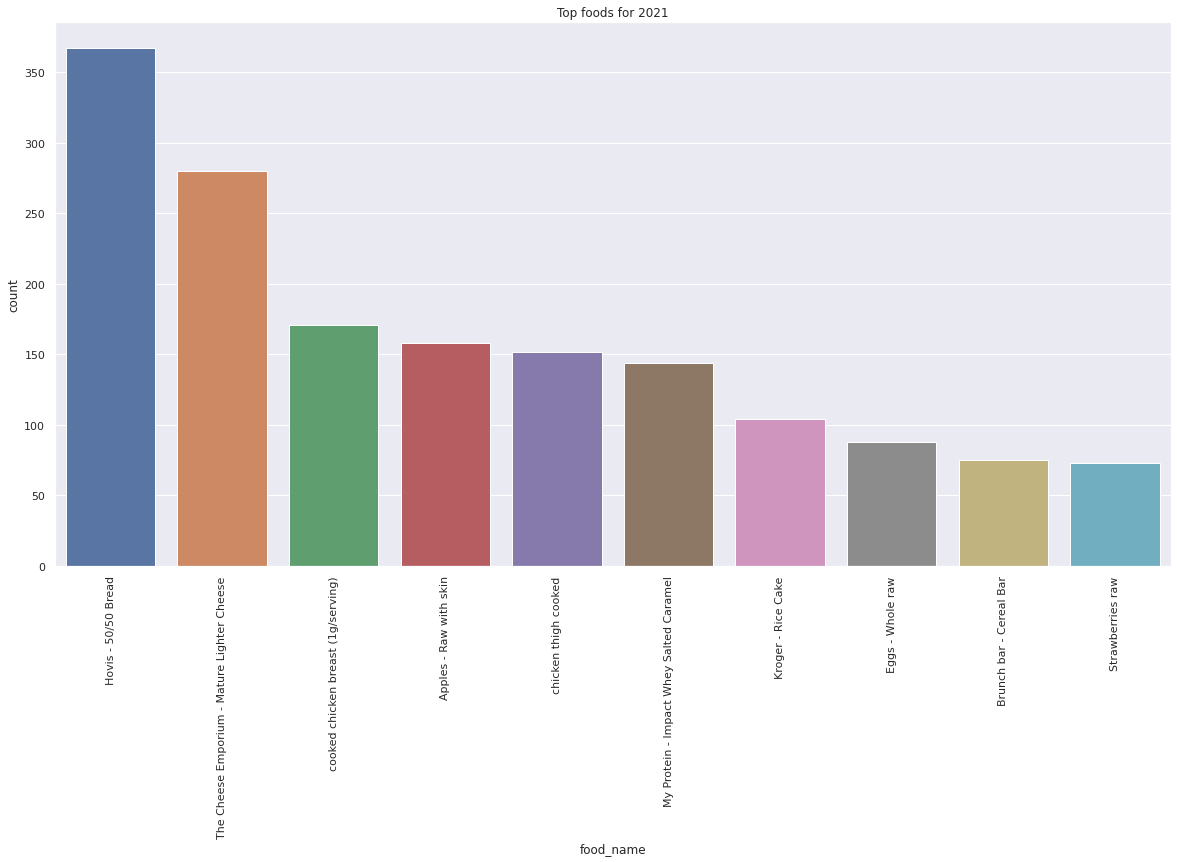

In [12]:
#group by food name for repeatable analysis
food_name_group = food_df.groupby('food_name')

food_counts_df = food_name_group.count().sort_values('calories_kcal', ascending=False)
food_counts_df = food_counts_df.iloc[:, 1].reset_index()
food_counts_df.columns = ['food_name', 'count']
sns.set_style()
sns.set_theme()
ax = sns.barplot(x='food_name', y='count', data= food_counts_df[0:10])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.figure.set_size_inches(20,10)
ax.set_title('Top foods for 2021')

In [13]:
bread_rows = food_df[food_df['food_name']=='Hovis - 50/50 Bread']

#get number of sliced from food_qty string
total_bread_slices = bread_rows['food_qty'].apply(lambda x:float(x.split()[0])).sum()
total_bread_cals = bread_rows['calories_kcal'].sum()
total_bread_carbs = bread_rows['carbs_g'].sum()

print(f"{total_bread_slices} slices of bread,\
         {total_bread_carbs} grams of carbs and \
             {total_bread_cals} calories\nI guess I like bread!")

802.5 slices of bread,         12845 grams of carbs and              73029 calories
I guess I like bread!


Summarise totals for each food

In [14]:
#total values for macronutrients grouped by foods
food_totals_df = food_name_group.sum()[['calories_kcal', 'carbs_g', 'fat_g', 'protein_g', 'sugar_g', 'fiber_g']]

### Most common sources for calories and macronutrients

In [15]:
top_cal_source = food_totals_df.sort_values('calories_kcal', ascending=False).iloc[0]
top_carb_source = food_totals_df.sort_values('carbs_g', ascending=False).iloc[0]
top_fat_source = food_totals_df.sort_values('fat_g', ascending=False).iloc[0]
top_protein_source = food_totals_df.sort_values('protein_g', ascending=False).iloc[0]

print(f"top calorie source: {top_cal_source.name}\n\
            \nmost common sources of macros:\n\t\
            carbs: {top_carb_source.name}\n\t\
            protein: {top_protein_source.name}\n\t\
            fats: {top_fat_source.name}")

top calorie source: Hovis - 50/50 Bread
            
most common sources of macros:
	            carbs: Hovis - 50/50 Bread
	            protein: cooked chicken breast (1g/serving)
	            fats: The Cheese Emporium - Mature Lighter Cheese


#### Now that I think of it, this is a pretty typical meal
![chicken cheese melt](images/chicken-cheese-sandwich.jpg)

#### Although the above analysis showed us the highest contributors to my fat/protein/carb intake - all top contributors are dominated by the same foods i.e. bread, cheese and chicken

##### you can see that bread and cheese are in the top 5 contributors to protein also, even though bread isn't typically eaten for its protein content

In [16]:
food_totals_df.sort_values('protein_g', ascending=False).head()

,calories_kcal,carbs_g,fat_g,protein_g,sugar_g,fiber_g
food_name,,,,,,
cooked chicken breast (1g/serving),46955,0,1009,8779,0,0
chicken thigh cooked,42854,0,1481,6948,0,0
My Protein - Impact Whey Salted Caramel,25531,274,501,5052,274,0
Hovis - 50/50 Bread,73029,12845,427,3210,1179,1605
The Cheese Emporium - Mature Lighter Cheese,35088,278,2471,2939,277,277


#### another option is to categorise foods based on their dominant macronutrient (this can be done by caloric value but I chose grams since I usually aim for a target based on grams) 
    - this means that cheese is counted as a "protein food" even though its a fairly even split between protein (8g) and fat (9g) content

In [17]:
# add a primary macro nutrient column to categorise food into carb, fat or protein source by max of grams
food_df['major_macro'] = food_df[macro_cols[0:3]].idxmax(axis=1)\
                                                    .apply(lambda x:x.split("_")[0])
food_df['major_macro_g'] = food_df[macro_cols[0:3]].max(axis=1)

food_df[['food_name','carbs_g', 'fat_g', 'protein_g','major_macro','major_macro_g']].head()

,food_name,carbs_g,fat_g,protein_g,major_macro,major_macro_g
0,Eggs - White only raw,1,0,11,protein,11
1,Eggs - Whole raw,1,13,17,protein,17
2,Apples - Raw with skin,35,0,1,carbs,35
3,The Cheese Emporium - Mature Lighter Cheese,1,7,8,protein,8
4,Hovis - 50/50 Bread,48,2,12,carbs,48


In [18]:
#add frequency column
food_df['freq'] = food_df['food_name'].map(food_df['food_name'].value_counts())

In [19]:
#get top 5 sources (by frequency) for each macro 
top_foods_freq_df = food_df.drop_duplicates('food_name')\
                        .groupby('major_macro', as_index=False)\
                            .apply(lambda x:x.nlargest(5, 'freq'))\
                                .reset_index(drop=True)

/home/ismail/Projects/data_sci/fit-progress/venv/lib/python3.8/site-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


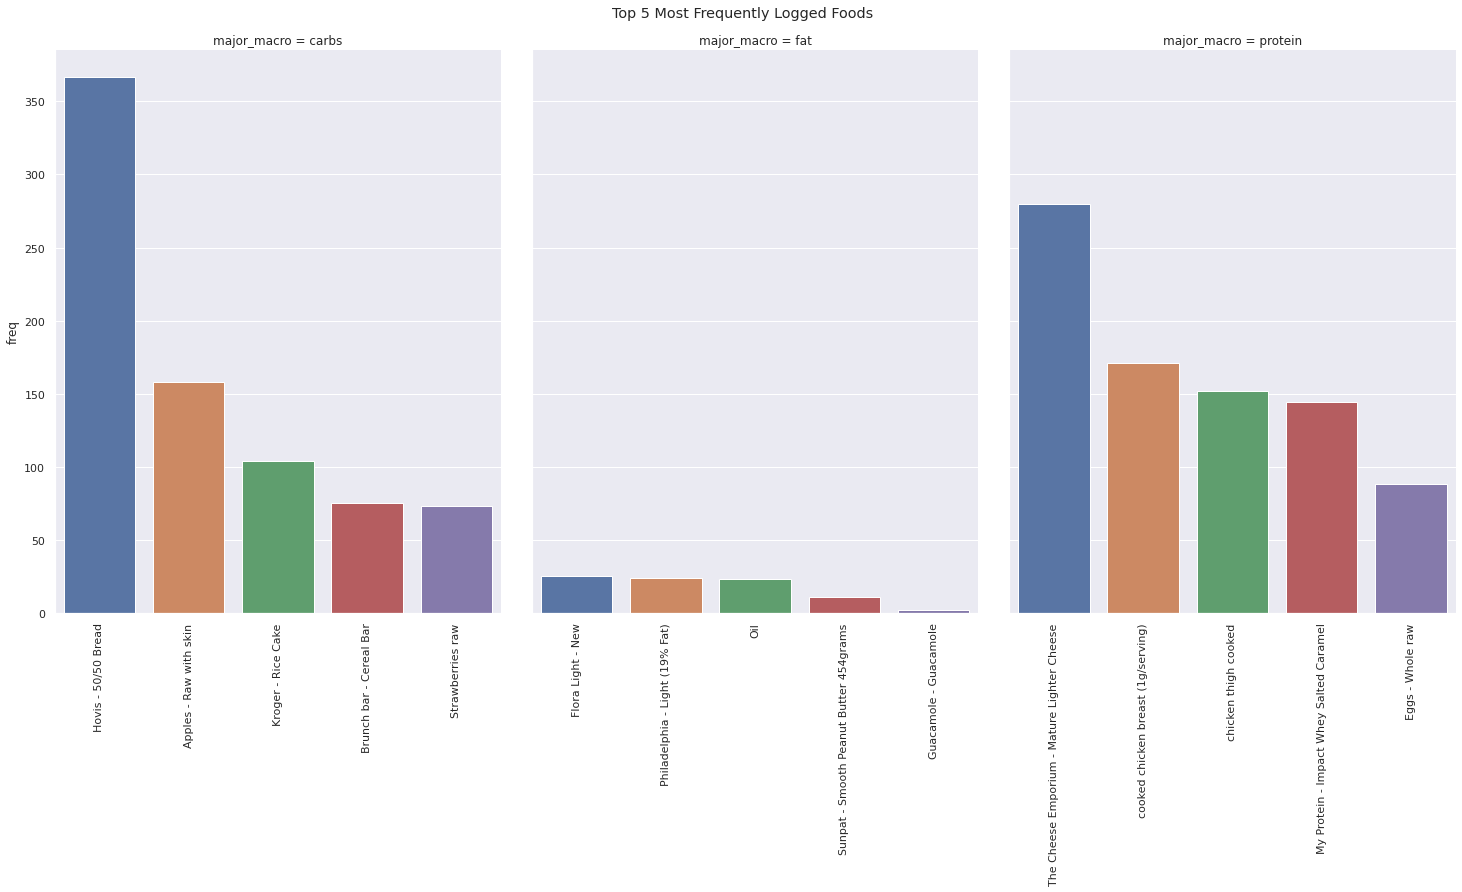

In [20]:
grid = sns.catplot(data =top_foods_freq_df, 
                    y='freq', 
                    x='food_name', 
                    kind='bar',
                    col='major_macro',
                    sharex=False,
                    palette=sns.color_palette('deep'),
                    aspect = 2.5 )
                    
grid.figure.set_size_inches(20,10)
grid.despine = True
grid.figure.suptitle('Top 5 Most Frequently Logged Foods')
for ax in grid.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    ax.set_xlabel("")

In [21]:
top_foods_g_df = food_df.groupby("food_name", as_index=False).agg({"major_macro_g":sum, 
                                                    "major_macro":max})\
                                                        .groupby("major_macro", as_index=False)\
                                                            .apply(lambda x:x.nlargest(5, "major_macro_g"))\
                                                                .reset_index(drop=True)

Key differences when plotting grams vs frequency:
- Strawberries are logged more frequently but they don't make the top 5 sources since they have a low carb content (they're actually my favourite low carb snack)
- Naan is pretty dense in carbs so it still contributes 3rd highest carbs to my diet even though I don't log them frequently

/home/ismail/Projects/data_sci/fit-progress/venv/lib/python3.8/site-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


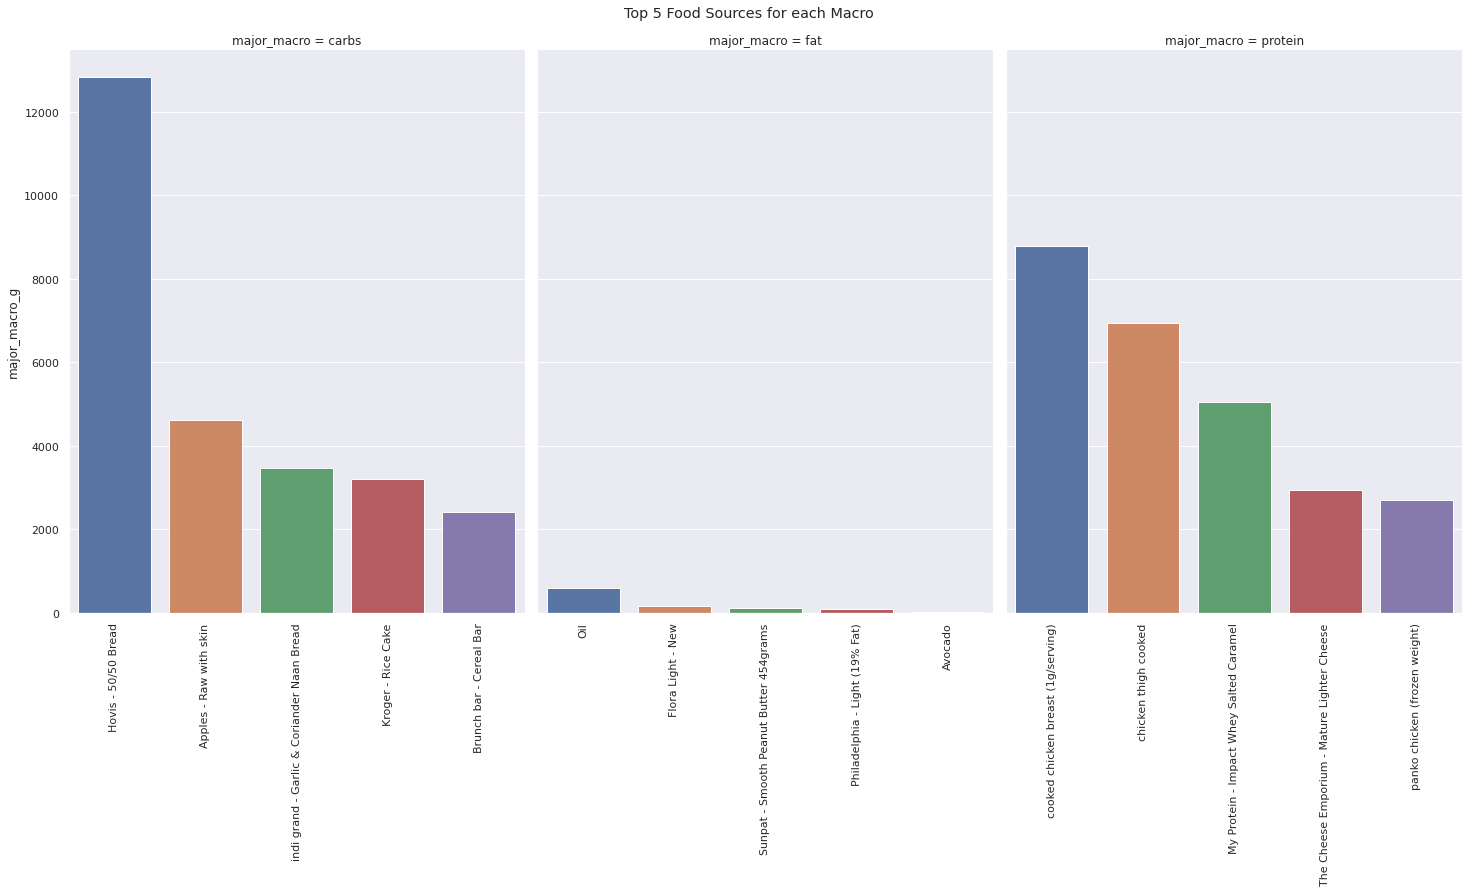

In [22]:
grid = sns.catplot(data =top_foods_g_df, 
                    y='major_macro_g', 
                    x='food_name', 
                    kind='bar',
                    col='major_macro',
                    sharex=False,
                    palette=sns.color_palette('deep'),
                    aspect = 2.5 )
                    
grid.figure.set_size_inches(20,10)
grid.despine = True
grid.figure.suptitle('Top 5 Food Sources for each Macro')
for ax in grid.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    ax.set_xlabel("")

#### before we start doing any further analysis, it's important to check for any missing data - how consistent was I with tracking my food?

In [23]:
days_tracked = len(food_df['date'].apply(lambda x:x.date()).unique())
print(f"{days_tracked} days of food tracked in 2021")

364 days of food tracked in 2021


so close to full marks! which day let me down?

In [24]:
dates_2021 = pd.date_range(date(2021,1,1), date(2022,1,1), inclusive='left')
doomsday = dates_2021.difference(food_df['date'])

In [25]:
print(f"the only day of the year i didn't track was {doomsday[0].strftime('%a-%b-%y')}")

the only day of the year i didn't track was Sat-Jan-21


Since I eat the same foods most days, i'll fill in this missing data by copying the entry for the next day (31-1-21)

In [26]:
missing_data = food_df[food_df['date'].apply(lambda x:x.date()==date(2021,1,31))].copy()
missing_data['date'] = pd.to_datetime(date(2021, 1,30),)
food_df_full = pd.concat([food_df, missing_data])

# double check all days are filled
print(len(food_df_full['date'].apply(lambda x:x.date()).unique()), 'days of 2021 covered')

365 days of 2021 covered


How do my eating habits change during the course of the week? 
 - do I eat more on the weekends?
 - do my food choices change - i.e. more convenience foods on weekdays
 - do i snack more often on the weekend?

In [27]:
#add weekday column for easier analysis
food_df_full['weekday'] = food_df_full['date'].apply(lambda x:x.weekday())
#how many times did that weekday occur in 2021?
weekday_entries =  food_df_full.drop_duplicates("date").groupby('weekday').count()['date']
weekday_totals = food_df_full.groupby('weekday').sum()[macro_cols[0:3]]
avg_weekday = weekday_totals.div(weekday_entries, axis=0)

#### There doesn't seem to be any significant differences in consumption throughout the week

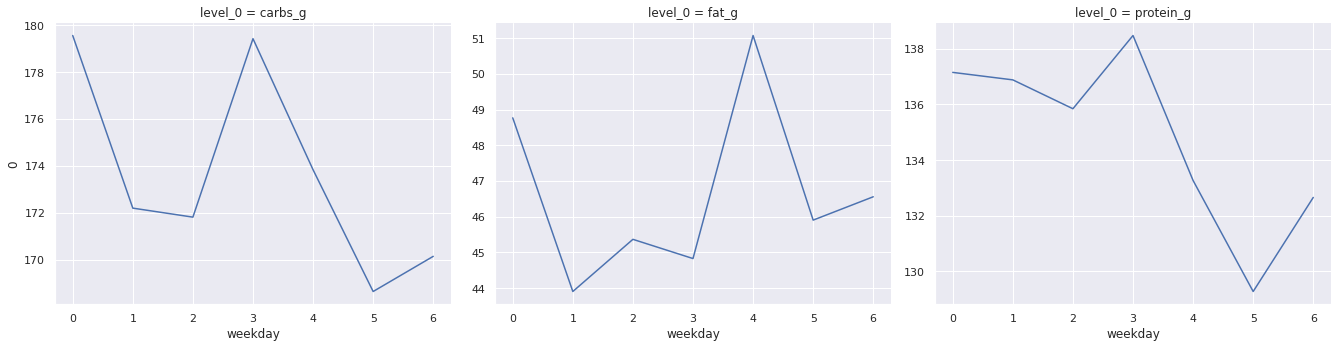

In [29]:
g = sns.FacetGrid(avg_weekday.unstack().reset_index(), col='level_0', sharey=False, height = 5, aspect = 1.25)
g.map(sns.lineplot, "weekday", 0)

In [145]:
avg_daily_calories = food_df_full.groupby('date').mean()[['calories_kcal','weekday']]
avg_daily_calories.columns = ['avg_kcal', 'weekday']
num_food_entries = food_df_full.groupby('date').count().iloc[:,0]

snacking_df = avg_daily_calories.join(num_food_entries)
snacking_df.columns = ['avg_food_entry_kcal','weekday', 'num_food_entries']
snacking_df.head()

,avg_food_entry_kcal,weekday,num_food_entries
date,,,
2021-01-01,183.538462,4.0,13
2021-01-02,184.000000,5.0,10
2021-01-03,217.222222,6.0,9
2021-01-04,168.692308,0.0,13
2021-01-05,182.090909,1.0,11


#### as expected: an negative correlation between number of food entries and kcal per food entry (i.e. it is a good indicator of how much I snack)

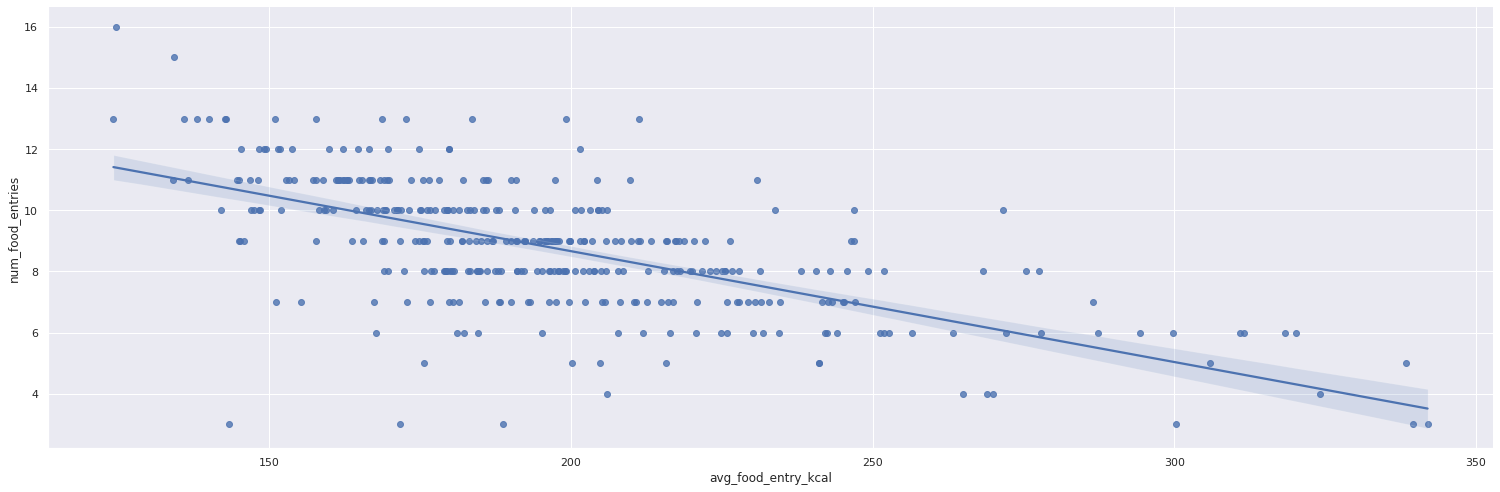

In [146]:
sns.lmplot(x='avg_food_entry_kcal', y='num_food_entries', data = snacking_df, height=7, aspect = 3)

#### There seems to be a lower amount of snacking between April and May - i.e. more calorically dense food and fewer entries...

#### which coincides with [Ramadan](https://en.wikipedia.org/wiki/Ramadan) in 2021! It's a month of fasting where the eating window is reduced, so it makes sense that I chose to eat more dense foods to ensure I still ate enough calories

Text(0.5, 1.0, 'Snacking trends in 2021')

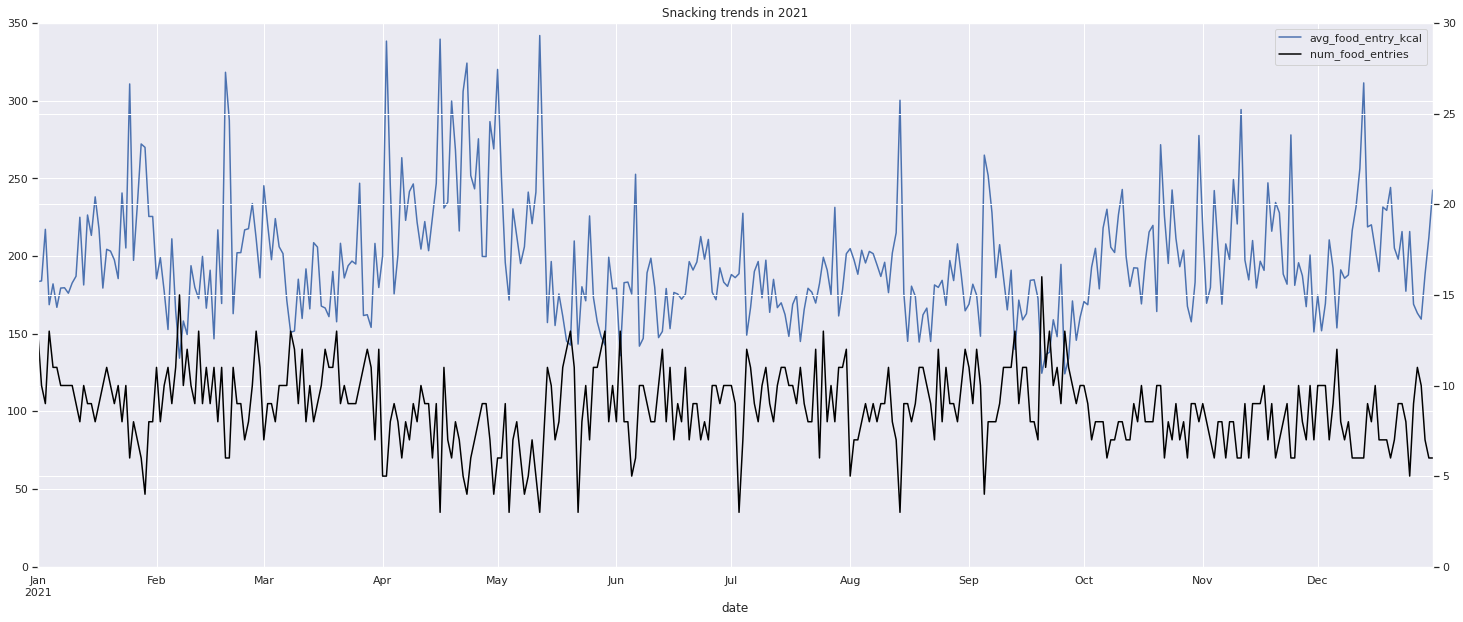

In [147]:
snacking_df.reset_index(inplace=True)
ax = snacking_df.plot(x='date', y='avg_food_entry_kcal', legend=False)
ax2 = ax.twinx()
ax.set_ylim(0,350)
snacking_df.plot(x='date', y='num_food_entries', ax=ax2, color='black',legend=False)
ax2.set_ylim(0,30)
ax.figure.legend(loc ='upper right',  bbox_to_anchor=(0.9,0.88))
ax.figure.set_size_inches((25,10))
ax.set_title("Snacking trends in 2021")

I thought I'd snack more on weekends compared to weekdays - but again no trend 😞 damn i'm boring

Text(0.5, 1.0, 'Average Snacking trends by Day of Week in 2021')

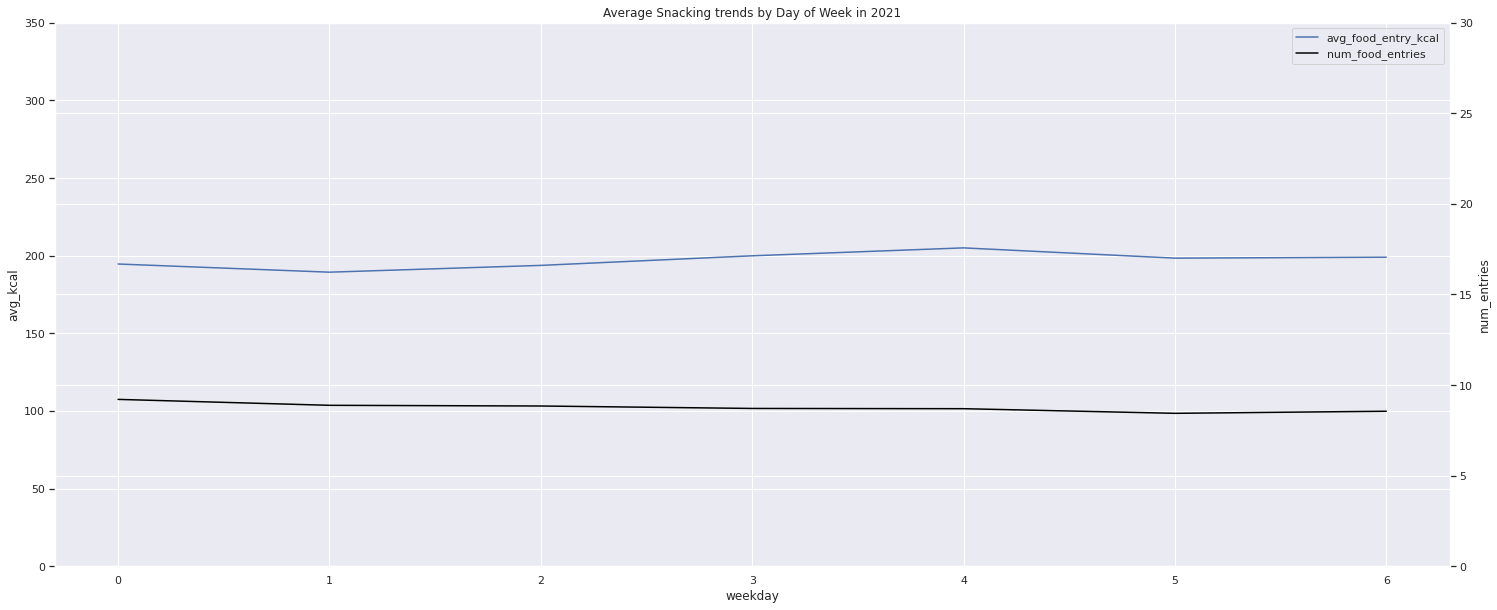

In [157]:
snacking_weekday_df = snacking_df.groupby('weekday').mean().reset_index()

ax = snacking_weekday_df.plot(x='weekday', y='avg_food_entry_kcal', legend=False)
ax2 = ax.twinx()
ax.set_ylim(0,350)
ax.set_ylabel("avg_kcal")
snacking_weekday_df.plot(x='weekday', y='num_food_entries', ax=ax2, color='black',legend=False)
ax2.set_ylim(0,30)
ax2.set_ylabel("num_entries")

ax.figure.legend(loc ='upper right',  bbox_to_anchor=(0.9,0.88))
ax.figure.set_size_inches((25,10))
ax.set_title("Average Snacking trends by Day of Week in 2021")

In [104]:
#maybe plot all lines on the same axis as a percentage of goal e.g. add column for carb, fat and protein % from goal macros - will help normalise axis too

#### Finally lets see how my adherence changes over the year

I will measure adherence as the absolute percentage difference between goal and actual intake

    - e.g. if my calorie goal was 2000 and I ate 2200 that would be assessed as |(2000-2200)|/2000 = 90% adherence

In [54]:
# summarise intake for each day
sum_cols = {col:'sum' for col in ['calories_kcal', 'carbs_g', 'fat_g', 'protein_g', 'sugar_g', 'fiber_g']}

#goal intake is repeated for each row in the day, so a average will just return the same value
all_cols = {**sum_cols, **{col:'mean' for col in ['goal_calories_kcal', 'goal_carbs_g', 'goal_fat_g', 'goal_protein_g', 'goal_sugar_g', 'goal_fiber_g']}}

In [55]:
food_df_full.groupby("date").agg(all_cols)

,calories_kcal,carbs_g,fat_g,protein_g,sugar_g,fiber_g,goal_calories_kcal,goal_carbs_g,goal_fat_g,goal_protein_g,goal_sugar_g,goal_fiber_g
date,,,,,,,,,,,,
2021-01-01,2386,247,79,178,86,20,2000.0,225.0,56.0,150.0,99.0,38.0
2021-01-02,1840,212,47,137,61,40,2000.0,225.0,56.0,150.0,99.0,38.0
2021-01-03,1955,254,45,135,85,41,2000.0,225.0,56.0,150.0,99.0,38.0
2021-01-04,2193,270,55,152,89,49,2000.0,225.0,56.0,150.0,99.0,38.0
2021-01-05,2003,231,49,158,75,52,1800.0,180.0,50.0,158.0,99.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1796,165,53,147,71,16,1800.0,180.0,50.0,158.0,99.0,38.0
2021-12-28,1594,188,30,145,99,21,1800.0,180.0,50.0,158.0,99.0,38.0
2021-12-29,1317,92,61,96,38,7,1800.0,180.0,50.0,158.0,99.0,38.0
